## Lab 7.8.1 - Polynomial Regression and Step function

I follow 
[JWarmenhoven](https://nbviewer.jupyter.org/github/JWarmenhoven/ISLR-python/blob/master/Notebooks/Chapter%207.ipynb)
to learn how to code the new materials

#### Import block

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

from patsy.splines import bs
from patsy.highlevel import dmatrix, dmatrices
from patsy.builtins import cr

%matplotlib inline
plt.style.use('seaborn-white')

Import data

In [9]:
data_path = 'D:\\PycharmProjects\\ISLR\\data\\'
df = pd.read_csv(f'{data_path}Wage.csv')

# first look
df.head(3)

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


First we want to see how 7.1 is produced. Using anova to identify best polynomial features. 

In [10]:
# Create poly dictionary to hold all polynomial features of X
poly_dict = {}

# Set up polynomial features
for i in range(1,6):
    poly = PolynomialFeatures(i)
    poly_dict[f'X{i}'] = poly.fit_transform(df.age.values.reshape(-1,1))
    
# Find a suitable degree
regr_list = []
for i in range(1, 6):
    regr_list.append(sm.GLS(df.wage, poly_dict.get(f'X{i}')).fit())

# Anova
sm.stats.anova_lm(*regr_list, typ=1)

# Choose X and y
X = poly_dict.get('X4')
y = (df.wage > 250).map({False:0, True:1}).values

d:\pycharmprojects\islr\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
d:\pycharmprojects\islr\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
d:\pycharmprojects\islr\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Why does he use sm.GLM from statsmodel? How does that differ than using the traditional
linear regression? 

In [11]:
# Run regression with X4
logistic = sm.GLM(y, X, family=sm.families.Binomial(sm.families.links.logit))
regr = logistic.fit()

# Create age grids
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Prediction
X_test = PolynomialFeatures(degree=4).fit_transform(age_grid)
y_pred = regr.predict(X_test)

d:\pycharmprojects\islr\venv\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


Text(0, 0.5, 'Pr(wage>250|age)')

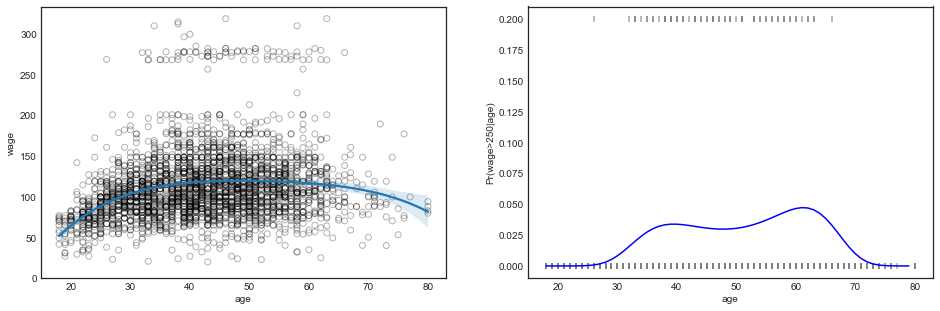

In [12]:
# Set up plots
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))

# Left plot (Polynomial)
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
sns.regplot(df.age, df.wage, order = 4, truncate=True, scatter=False, ax=ax1)
ax1.set_ylim(ymin=0)

# Right plot (glm)
ax2.plot(age_grid, y_pred, color='b')

# Separate age into bins and plot the distribution
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

# plot labels
ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

#### Step function

In [13]:
# Cut age into 4 bins
df_cut, bins = pd.cut(df.age, bins=4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

In [14]:
# Create a step dataframe
df_steps = pd.concat([df.age, df_cut, df.wage], keys=['age', 'age_cut', 'wage'], axis=1)
df_steps.head()

,age,age_cut,wage
0,18,"(17.938, 33.5]",75.043154
1,24,"(17.938, 33.5]",70.476020
2,45,"(33.5, 49.0]",130.982177
3,43,"(33.5, 49.0]",154.685293
4,50,"(49.0, 64.5]",75.043154


In [15]:
# Create a dummy variables for each age group
df_steps_dummies = pd.get_dummies(df_steps['age_cut'])

# Adding constant for statsmodel 
df_steps_dummies = sm.add_constant(df_steps_dummies)

df_steps_dummies.head()

d:\pycharmprojects\islr\venv\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,1,0,0,0
1,1.0,1,0,0,0
2,1.0,0,1,0,0
3,1.0,0,1,0,0
4,1.0,0,0,1,0


We are ignoring the first bin

In [16]:
# Fit GLM onto the step dataframe
regr = sm.GLM(df_steps.wage, df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1)).fit()
regr.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.468,27.639
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.611,27.718
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.135,17.416


In [17]:
# Put test data in same bin as train data
bin_mapping = np.digitize(age_grid.ravel(), bins)
print(bin_mapping)

# Get dummy variable and rop first bin
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis=1))
X_test2.head()

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


,const,2,3,4
0,1.0,0,0,0
1,1.0,0,0,0
2,1.0,0,0,0
3,1.0,0,0,0
4,1.0,0,0,0


#### Linear Regression

In [18]:
linear_pred = regr.predict(X_test2)

#### Logistic Regression

In [19]:
logistic = sm.GLM(y, df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1),
              family=sm.families.Binomial(sm.families.links.logit))
regr = logistic.fit()
logit_pred = regr.predict(X_test2)

d:\pycharmprojects\islr\venv\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


### Figure 7.2

Text(0, 0.5, 'Pr(wage>250|age)')

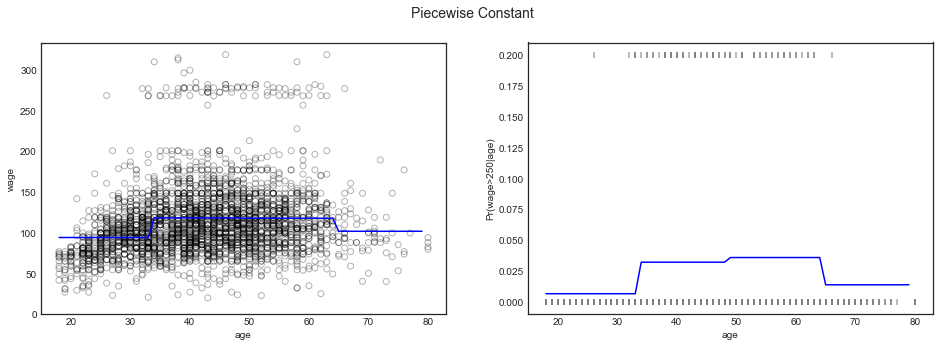

In [20]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, linear_pred, c='b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), logit_pred, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

### 7.8.2 - Splines

The bs function from patsy produces the basis matrix needed to construct splines.
Each row of the matrix represent the basis function for each knots that we specified.
Then we can fit linear regression onto this matrix function to produce splines.
Read more [here](https://patsy.readthedocs.io/en/latest/spline-regression.html)

#### Cubic splines with 3 knots

Remember cubic splines returns K+3 coefficients (where K is the number of knots).
Thus, with 3 knots we have 3+4 = 7 coefficients (including intercept) or df=7

In [21]:
# Transform X into splines
X_transformed = dmatrix("bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)",
                        {'df.age':df.age}, return_type='dataframe')
X_test_transformed = dmatrix("bs(age_grid, knots=(25, 40, 60), degree=3, include_intercept=False)",
                        {'age_grid':age_grid}, return_type='dataframe')

# fit regression with the splines
regr = sm.GLM(df.wage, X_transformed).fit()
y_pred_3knots = regr.predict(X_test_transformed)

# return the coefficients
regr.params

Intercept                                                               60.493714
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.980500
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.630980
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.838788
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.990830
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.688098
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.606142
dtype: float64

Now we generate the splines using degree of freedom instead of knots. 6 df + 1 intercept
gives us the same 7 coefficients. In this case, the knots are chosen using quantile


In [22]:
# Splines with specified degree of freedom
X_transformed = dmatrix("bs(df.age, df=6, degree=3, include_intercept=False)",
                        {'df.age':df.age}, return_type='dataframe')
X_test_transformed = dmatrix("bs(age_grid, df=6, degree=3, include_intercept=False)",
                        {'age_grid':age_grid}, return_type='dataframe')

# fit regression onto splines
regr = sm.GLM(df.wage, X_transformed).fit()
y_pred_6df = regr.predict(X_test_transformed)

# return the coefficients
regr.params

Intercept                                                 56.313841
bs(df.age, df=6, degree=3, include_intercept=False)[0]    27.824002
bs(df.age, df=6, degree=3, include_intercept=False)[1]    54.062546
bs(df.age, df=6, degree=3, include_intercept=False)[2]    65.828391
bs(df.age, df=6, degree=3, include_intercept=False)[3]    55.812734
bs(df.age, df=6, degree=3, include_intercept=False)[4]    72.131473
bs(df.age, df=6, degree=3, include_intercept=False)[5]    14.750876
dtype: float64

#### Natural Splines
Natural splines are splines with constraints near X boundary to reduced large
variance at the edge. Fortunately, fitting natural splines are the same as bs but instead
we use cr for natural cubic regression. 

Again, df=4 means 5 coefficients (1 is intercept)

In [23]:
# Natural splines with 4 degree of freedom
X_transformed = dmatrix('cr(df.age, df=4)', {'df.age':df.age}, return_type='dataframe')
X_test_transformed = dmatrix('cr(age_grid, df=4)', {'age_grid':age_grid}, return_type='dataframe')

# Fit splines
regr = sm.GLM(df.wage, X_transformed).fit()
y_pred_natural_4df = regr.predict(X_test_transformed)

# return the coefficients
regr.params

Intercept              79.642095
cr(df.age, df=4)[0]   -14.667784
cr(df.age, df=4)[1]    36.811142
cr(df.age, df=4)[2]    35.934874
cr(df.age, df=4)[3]    21.563863
dtype: float64

Plotting splines together. Notice the edge of natural splines are much better than 
the other two. 

Thank you [JWarmenhoven](https://nbviewer.jupyter.org/github/JWarmenhoven/ISLR-python/blob/master/Notebooks/Chapter%207.ipynb)
for the tutorials

Text(0, 0.5, 'wage')

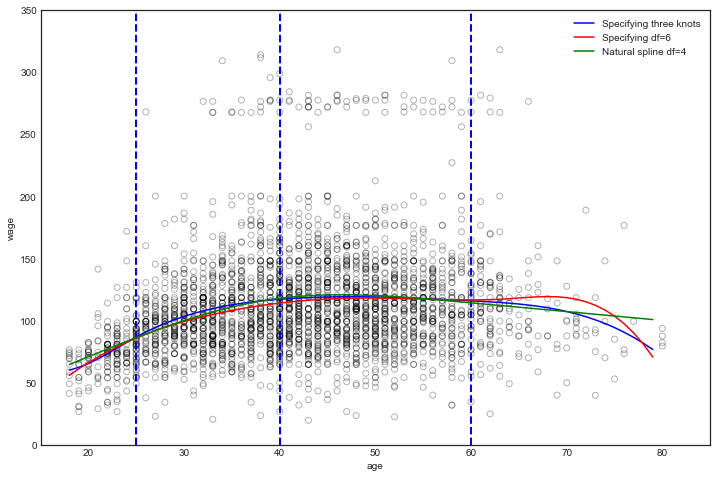

In [24]:
plt.figure(figsize=(12,8))
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(age_grid, y_pred_3knots, color='b', label='Specifying three knots')
plt.plot(age_grid, y_pred_6df, color='r', label='Specifying df=6')
plt.plot(age_grid, y_pred_natural_4df, color='g', label='Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')

#### Smoothing Splines

No module to do smoothing splines atm. However, scipy interpolate UnivariateSplines
can do smoothing on stricly increasing X. 

I will come back later.
